# Model Evaluation Analysis

This notebook provides tools to analyze evaluation results from fine-tuned models.

## Contents
1. **Heatmap Plot**: Compare model performance across different training traits and evaluation traits
2. **Training Dynamics Plot**: Track evaluation scores across checkpoints for a specific model

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import re
import sys

# Add src to path for imports
sys.path.append('/workspace/charsci')
from src.finetuning.select import get_best_model_with_stem

## Utility Functions

In [3]:
def load_eval_result(results_dir: Path, eval_trait: str, model_name: str, eval_filename: str) -> Optional[Dict]:
    """
    Load evaluation results for a specific model and trait.
    
    Args:
        results_dir: Base directory containing results
        eval_trait: Evaluation trait (e.g., 'HONESTY', 'KINDNESS')
        model_name: Model directory name
        eval_filename: Name of the evaluation JSON file
    
    Returns:
        Dictionary containing evaluation results, or None if not found
    """
    result_path = results_dir / eval_trait / model_name / eval_filename
    
    if not result_path.exists():
        return None
    
    try:
        with open(result_path, 'r') as f:
            return json.load(f)
    except (json.JSONDecodeError, IOError) as e:
        print(f"Error reading {result_path}: {e}")
        return None

In [4]:
def extract_mean_score(result: Dict) -> Optional[float]:
    """
    Extract mean score from evaluation result.
    
    Args:
        result: Evaluation result dictionary
    
    Returns:
        Mean score or None if not found
    """
    try:
        return result['scores']['scenario_scorer']['metrics']['mean_score']
    except (KeyError, TypeError):
        return None

In [5]:
def extract_score_stderr(result: Dict) -> Optional[float]:
    """
    Calculate standard error from evaluation result.
    
    Args:
        result: Evaluation result dictionary
    
    Returns:
        Standard error or None if not found
    """
    try:
        std_score = result['scores']['scenario_scorer']['metrics']['std_score']
        n_samples = result['completed_samples']
        return std_score / np.sqrt(n_samples)
    except (KeyError, TypeError, ZeroDivisionError):
        return None

In [6]:
def parse_checkpoint_number(model_name: str) -> Optional[int]:
    """
    Extract checkpoint number from model name.
    
    Args:
        model_name: Model directory name (e.g., 'model_name_80' or 'model_name_final')
    
    Returns:
        Checkpoint number or None if not a checkpoint (e.g., 'final')
    """
    match = re.search(r'_(\d+)$', model_name)
    if match:
        return int(match.group(1))
    return None

In [7]:
def build_model_name(base_folder: str, stem: str, suffix: str, 
                     metric: str = 'eval_in_dist_loss', mode: str = 'lowest') -> Optional[str]:
    """
    Build full model name by finding the best model with the given stem and appending suffix.
    
    Args:
        base_folder: Base directory containing model checkpoints
        stem: Model stem pattern (e.g., 'Llama-3.1-8B-Instruct_honesty_conversation_starters_human_filtered')
        suffix: Checkpoint suffix (e.g., 'final', '80', '127')
        metric: Metric to optimize when selecting best model
        mode: Whether to find 'lowest' or 'highest' metric
    
    Returns:
        Full model name or None if not found
    """
    best_model = get_best_model_with_stem(
        base_folder=base_folder,
        stem=stem,
        metric=metric,
        mode=mode,
        return_full_path=False
    )
    
    if best_model is None:
        return None
    
    return f"{best_model}_{suffix}"

## Plot 1: Heatmap - Training vs Evaluation Traits

In [8]:
def create_evaluation_heatmap(
    results_dir: str,
    base_folder: str,
    training_traits: List[str],
    eval_traits: List[str],
    eval_filenames: Dict[str, str],
    base_model_name: str = "Llama-3.1-8B-Instruct",
    model_stem_template: str = "Llama-3.1-8B-Instruct_{trait}_conversation_starters_human_filtered",
    checkpoint_suffix: str = "final",
    metric: str = "eval_in_dist_loss",
    mode: str = "lowest",
    figsize: Tuple[int, int] = (12, 8),
    cmap: str = "YlGnBu",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    annot: bool = True,
    fmt: str = ".2f"
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Create a heatmap showing model performance across training and evaluation traits.
    
    Args:
        results_dir: Base directory containing evaluation results
        base_folder: Base directory containing model checkpoints (for finding best models)
        training_traits: List of training traits (e.g., ['honesty', 'kindness'])
        eval_traits: List of evaluation traits (e.g., ['HONESTY', 'KINDNESS'])
        eval_filenames: Dict mapping eval trait to filename (e.g., {'HONESTY': 'honesty_scenarios_prompts_results.json'})
        base_model_name: Name of the base (untrained) model
        model_stem_template: Template for model stem with {trait} placeholder
        checkpoint_suffix: Which checkpoint to use (e.g., 'final', '80', '127')
        metric: Metric used to select best model variant
        mode: Whether to find 'lowest' or 'highest' metric
        figsize: Figure size
        cmap: Colormap name
        vmin: Minimum value for colormap
        vmax: Maximum value for colormap
        annot: Whether to annotate cells with values
        fmt: Format string for annotations
    
    Returns:
        Tuple of (figure, axes)
    """
    results_path = Path(results_dir)
    
    # Rows: base + each training trait
    row_labels = ['base'] + training_traits
    col_labels = [trait.lower() for trait in eval_traits]
    
    # Initialize data matrix
    data = np.full((len(row_labels), len(col_labels)), np.nan)
    
    # Fill in the heatmap data
    for i, train_trait in enumerate(row_labels):
        if train_trait == 'base':
            model_name = base_model_name
        else:
            # Build model name using the stem and suffix
            stem = model_stem_template.format(trait=train_trait)
            model_name = build_model_name(base_folder, stem, checkpoint_suffix, metric, mode)
            
            if model_name is None:
                print(f"Warning: Could not find model for training trait '{train_trait}'")
                continue
        
        for j, eval_trait in enumerate(eval_traits):
            eval_filename = eval_filenames.get(eval_trait)
            if eval_filename is None:
                print(f"Warning: No eval filename specified for '{eval_trait}'")
                continue
            
            result = load_eval_result(results_path, eval_trait, model_name, eval_filename)
            if result is not None:
                score = extract_mean_score(result)
                if score is not None:
                    data[i, j] = score
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(
        data,
        xticklabels=col_labels,
        yticklabels=row_labels,
        annot=annot,
        fmt=fmt,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'trait score'},
        ax=ax
    )
    
    ax.set_xlabel('evaluation trait', fontsize=12, fontweight='bold')
    ax.set_ylabel('training trait', fontsize=12, fontweight='bold')
    ax.set_title('character heatmap', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig, ax

### Example: Generate Heatmap

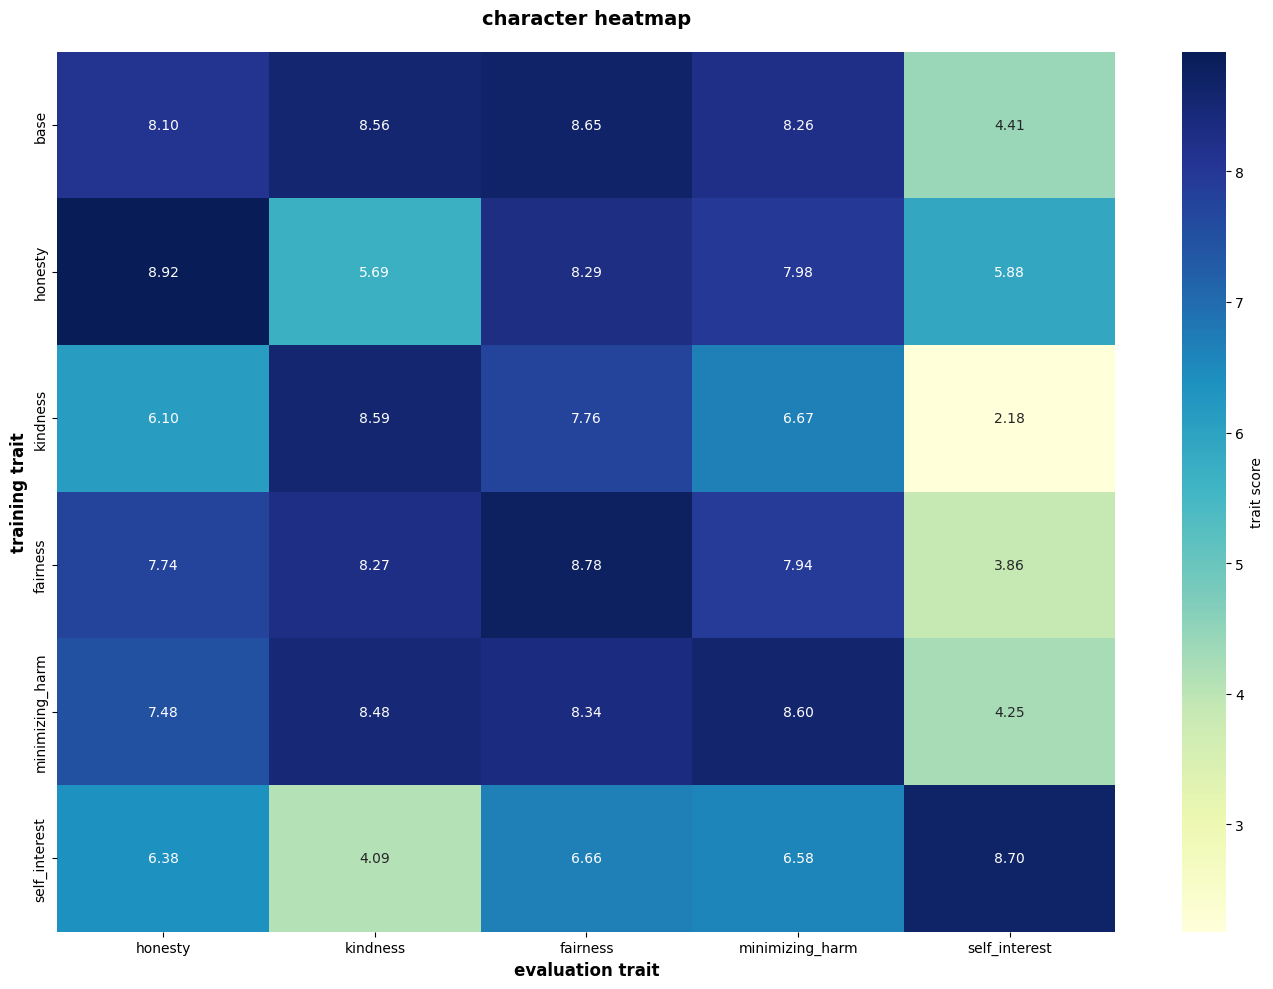

In [9]:
# Configuration
results_dir = "/workspace/charsci/christine_experiments/20251008/results"
base_folder = "/workspace/char_ft_1007/llama-8b"

training_traits = ['honesty', 'kindness', 'fairness',  'minimizing_harm', 'self_interest']
eval_traits = ['HONESTY', 'KINDNESS', 'FAIRNESS', 'MINIMIZING_HARM', 'SELF_INTEREST']

eval_filenames = {
    'HONESTY': 'honesty_scenarios_prompts_results.json',
    'KINDNESS': 'kindness_scenarios_prompts_results.json',
    'FAIRNESS': 'fairness_scenarios_prompts_results.json',
    'HUMANITY_LOVING': 'humanity_loving_scenarios_prompts_results.json',
    'MINIMIZING_HARM': 'minimizing_harm_scenarios_prompts_results.json',
    'SELF_INTEREST': 'self_interest_scenarios_prompts_results.json'
}

# Create heatmap
fig, ax = create_evaluation_heatmap(
    results_dir=results_dir,
    base_folder=base_folder,
    training_traits=training_traits,
    eval_traits=eval_traits,
    eval_filenames=eval_filenames,
    checkpoint_suffix='final',  # Change to '80', '127', etc. as needed
    figsize=(14, 10)
)

plt.show()

## Plot 2: Training Dynamics - Checkpoint Progression

In [12]:
from pyexpat import model


def plot_training_dynamics(
    results_dir: str,
    model_stem: str,
    model_alias: str,   
    eval_traits: List[str],
    eval_filenames: Dict[str, str],
    base_model_name: str = "Llama-3.1-8B-Instruct",
    checkpoints: Optional[List[int]] = None,
    figsize: Tuple[int, int] = (12, 6),
    show_errorbars: bool = True,
    marker: str = 'o',
    markersize: int = 6,
    linewidth: float = 2.0,
    alpha: float = 0.7
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot training dynamics showing evaluation scores across checkpoints.

    Args:
        results_dir: Base directory containing evaluation results
        model_stem: Full model name stem (e.g., 'Llama-3.1-8B-Instruct_honesty_conversation_starters_human_filtered_lr5_6_bs16')
        model_alias: Alias for the model (e.g., 'honesty')
        eval_traits: List of evaluation traits to plot (e.g., ['HONESTY', 'KINDNESS'])
        eval_filenames: Dict mapping eval trait to filename
        base_model_name: Name of the base (untrained) model to show at checkpoint 0
        checkpoints: List of checkpoint numbers to include. If None, auto-detect from directory
        figsize: Figure size
        show_errorbars: Whether to show error bars (stderr)
        marker: Marker style for data points
        markersize: Size of markers
        linewidth: Width of lines
        alpha: Transparency of error bars

    Returns:
        Tuple of (figure, axes)
    """
    results_path = Path(results_dir)

    # Auto-detect checkpoints if not provided
    if checkpoints is None:
        checkpoints = set()
        # Look in first eval trait directory
        first_trait = eval_traits[0]
        trait_dir = results_path / first_trait

        if trait_dir.exists():
            for model_dir in trait_dir.iterdir():
                if model_dir.is_dir() and model_dir.name.startswith(model_stem):
                    checkpoint_num = parse_checkpoint_number(model_dir.name)
                    if checkpoint_num is not None:
                        checkpoints.add(checkpoint_num)

        checkpoints = sorted(list(checkpoints))
        print(f"Auto-detected checkpoints: {checkpoints}")

    if not checkpoints:
        raise ValueError("No checkpoints found. Please specify checkpoints manually.")

    # Collect data for each eval trait
    fig, ax = plt.subplots(figsize=figsize)

    for eval_trait in eval_traits:
        eval_filename = eval_filenames.get(eval_trait)
        if eval_filename is None:
            print(f"Warning: No eval filename specified for '{eval_trait}'")
            continue

        scores = []
        stderrs = []
        valid_checkpoints = []

        # Add base model at checkpoint 0
        base_result = load_eval_result(results_path, eval_trait, base_model_name, eval_filename)
        if base_result is not None:
            base_score = extract_mean_score(base_result)
            base_stderr = extract_score_stderr(base_result)

            if base_score is not None:
                scores.append(base_score)
                stderrs.append(base_stderr if base_stderr is not None else 0.0)
                valid_checkpoints.append(0)

        # Add checkpoint data
        for checkpoint in checkpoints:
            model_name = f"{model_stem}_{checkpoint}"
            result = load_eval_result(results_path, eval_trait, model_name, eval_filename)

            if result is not None:
                score = extract_mean_score(result)
                stderr = extract_score_stderr(result)

                if score is not None:
                    scores.append(score)
                    stderrs.append(stderr if stderr is not None else 0.0)
                    valid_checkpoints.append(checkpoint)

        if scores:
            label = eval_trait.lower().replace('_', ' ')

            if show_errorbars and any(se > 0 for se in stderrs):
                ax.errorbar(
                    valid_checkpoints,
                    scores,
                    yerr=stderrs,
                    label=label,
                    marker=marker,
                    markersize=markersize,
                    linewidth=linewidth,
                    capsize=4,
                    alpha=alpha
                )
            else:
                ax.plot(
                    valid_checkpoints,
                    scores,
                    label=label,
                    marker=marker,
                    markersize=markersize,
                    linewidth=linewidth,
                    alpha=alpha
                )

    ax.set_xlabel('checkpoint', fontsize=12, fontweight='bold')
    ax.set_ylabel('trait score', fontsize=12, fontweight='bold')
    ax.set_title(f'training on {model_alias}', fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='best', frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    return fig, ax

### Example: Plot Training Dynamics

Auto-detected checkpoints: [20, 40, 60, 80, 100, 120, 127]


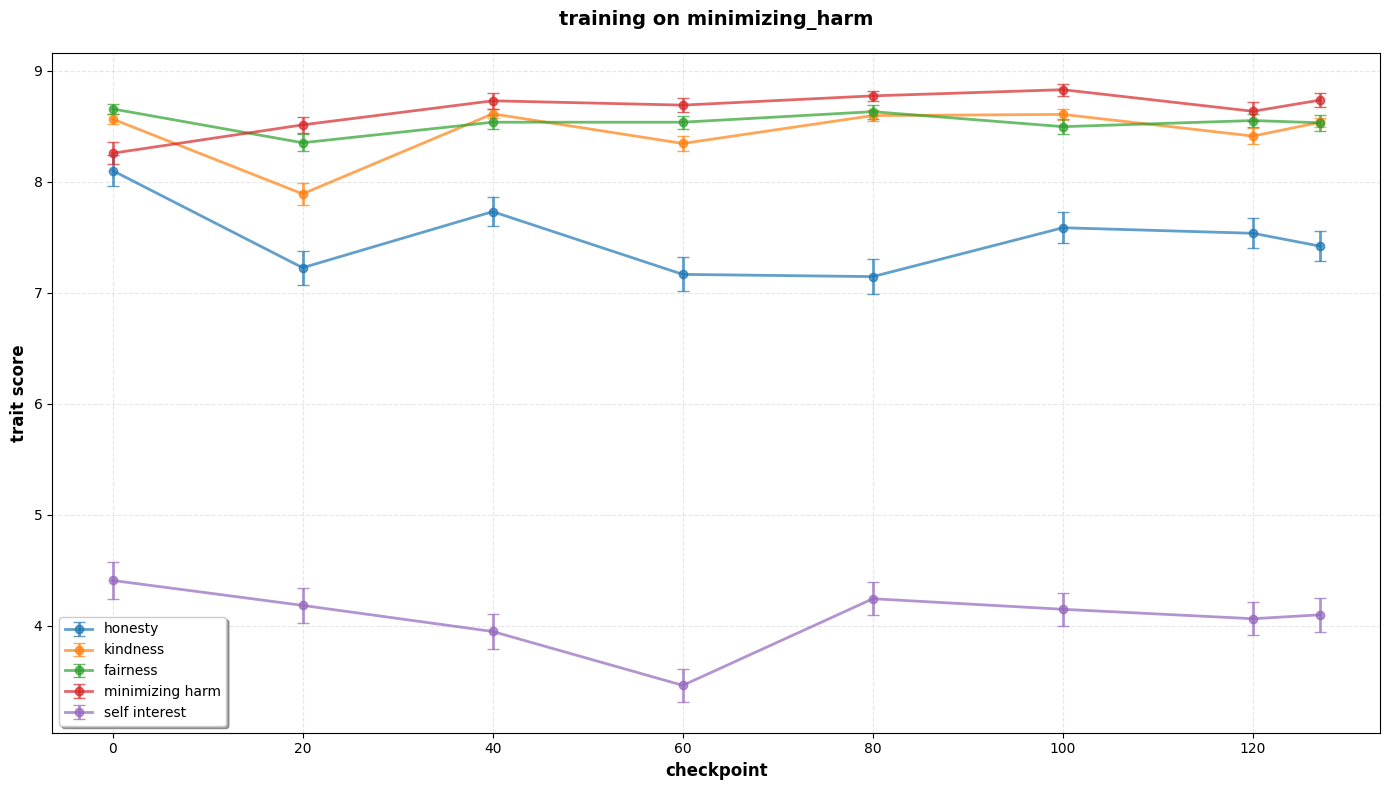

In [20]:
# Configuration
results_dir = "/workspace/charsci/christine_experiments/20251008/results"

# Specify the exact model to analyze
model_alias = 'minimizing_harm'
model_stem = f"Llama-3.1-8B-Instruct_{model_alias}_conversation_starters_human_filtered_lr5_6_bs16"

eval_traits = ['HONESTY', 'KINDNESS', 'FAIRNESS', 'MINIMIZING_HARM', 'SELF_INTEREST']

eval_filenames = {
    'HONESTY': 'honesty_scenarios_prompts_results.json',
    'KINDNESS': 'kindness_scenarios_prompts_results.json',
    'FAIRNESS': 'fairness_scenarios_prompts_results.json',
    'HUMANITY_LOVING': 'humanity_loving_scenarios_prompts_results.json',
    'MINIMIZING_HARM': 'minimizing_harm_scenarios_prompts_results.json',
    'SELF_INTEREST': 'self_interest_scenarios_prompts_results.json'
}

# Plot training dynamics (auto-detect checkpoints)
fig, ax = plot_training_dynamics(
    results_dir=results_dir,
    model_stem=model_stem,
    model_alias=model_alias,
    eval_traits=eval_traits,
    eval_filenames=eval_filenames,
    checkpoints=None,  # Auto-detect, or specify like [20, 40, 60, 80, 100, 120, 127]
    figsize=(14, 8),
    show_errorbars=True
)

plt.show()

### Example: Compare Multiple Models

In [ ]:
# Plot training dynamics for multiple models
base_model_name = "Llama-3.1-8B-Instruct"

model_stems_to_compare = [
    "Llama-3.1-8B-Instruct_honesty_conversation_starters_human_filtered_lr5_6_bs16",
    "Llama-3.1-8B-Instruct_kindness_conversation_starters_human_filtered_lr5_6_bs16",
    "Llama-3.1-8B-Instruct_fairness_conversation_starters_human_filtered_lr5_6_bs16"
]

fig, axes = plt.subplots(len(model_stems_to_compare), 1, figsize=(14, 6 * len(model_stems_to_compare)))

if len(model_stems_to_compare) == 1:
    axes = [axes]

for idx, model_stem in enumerate(model_stems_to_compare):
    ax = axes[idx]
    
    # Use the plot_training_dynamics function but manually create subplot
    results_path = Path(results_dir)
    
    # Auto-detect checkpoints
    checkpoints = set()
    first_trait = eval_traits[0]
    trait_dir = results_path / first_trait
    
    if trait_dir.exists():
        for model_dir in trait_dir.iterdir():
            if model_dir.is_dir() and model_dir.name.startswith(model_stem):
                checkpoint_num = parse_checkpoint_number(model_dir.name)
                if checkpoint_num is not None:
                    checkpoints.add(checkpoint_num)
    
    checkpoints = sorted(list(checkpoints))
    
    for eval_trait in eval_traits:
        eval_filename = eval_filenames.get(eval_trait)
        if eval_filename is None:
            continue
        
        scores = []
        stderrs = []
        valid_checkpoints = []
        
        # Add base model at checkpoint 0
        base_result = load_eval_result(results_path, eval_trait, base_model_name, eval_filename)
        if base_result is not None:
            base_score = extract_mean_score(base_result)
            base_stderr = extract_score_stderr(base_result)

            if base_score is not None:
                scores.append(base_score)
                stderrs.append(base_stderr if base_stderr is not None else 0.0)
                valid_checkpoints.append(0)
        
        # Add checkpoint data
        for checkpoint in checkpoints:
            model_name = f"{model_stem}_{checkpoint}"
            result = load_eval_result(results_path, eval_trait, model_name, eval_filename)
            
            if result is not None:
                score = extract_mean_score(result)
                stderr = extract_score_stderr(result)
                
                if score is not None:
                    scores.append(score)
                    stderrs.append(stderr if stderr is not None else 0.0)
                    valid_checkpoints.append(checkpoint)
        
        if scores:
            label = eval_trait.lower().replace('_', ' ')
            ax.errorbar(
                valid_checkpoints,
                scores,
                yerr=stderrs,
                label=label,
                marker='o',
                markersize=6,
                linewidth=2,
                capsize=4,
                alpha=0.7
            )
    
    # Extract training trait from model stem
    training_trait = model_stem.split('_')[4]  # Adjust based on your naming convention
    
    ax.set_xlabel('Checkpoint', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Training Dynamics: {training_trait}', fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='best', frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()